In [1]:
import sys
sys.path.append('segmentation')

from utils.image_gen import *
import seg_transforms
from data import AdaptTransform
from nets.SegAttention import SegAttention
from torchvision import models
import cv2
from torch import nn
from PIL import Image as PILImage
import matplotlib as mpl
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image


def show_layout(images, titles=None, ticks=None):
    aux_titles = titles if titles is not None else {}
    fig = plt.figure(figsize=(25, 50))
    cmap = mpl.cm.Spectral_r
    for i in range(len(images)):
        sub = fig.add_subplot(11, 4, i + 1)
        sub.axis('off')
        if i < len(aux_titles):
            sub.set_title(titles[i])
        img = sub.imshow(images[i], interpolation='nearest')
        if i > 1 and i - 2 < len(ticks):
            norm = mpl.colors.Normalize(vmin=ticks[i][0], vmax=ticks[i][-1])
            cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=sub)
            tick_locator = mpl.ticker.LinearLocator(5)
            cbar.set_ticks(tick_locator)
            cbar.update_ticks()

In [2]:
# Constants
ATTRIBUTES = ["beautiful", "boring", "depressing", "lively", "safety", "wealthy"]
attribute = ATTRIBUTES[0]
MODEL_PATH = f'models/segattn_resnet_{attribute}.pth'
h, w = (244, 244)
CS_CLASSES = [
    'road',
    'sidewalk',
    'building',
    'wall',
    'fence',
    'pole',
    'traffic light',
    'traffic sign',
    'vegetation',
    'terrain',
    'sky',
    'person',
    'rider',
    'car',
    'truck',
    'bus',
    'train',
    'motorcycle',
    'bicycle'
]

In [3]:
IMG_MEAN = np.array((104.00698793, 116.66876762, 122.67891434), dtype=np.float32)
transformers = transforms.Compose([
    AdaptTransform(seg_transforms.ToArray()),
    AdaptTransform(seg_transforms.SubstractMean(IMG_MEAN)),
    AdaptTransform(seg_transforms.Resize((h, w))),
    AdaptTransform(seg_transforms.ToTorchDims()),

])

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

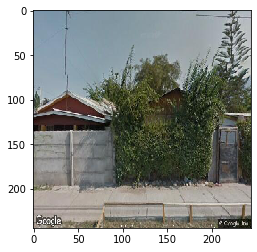

In [5]:
im = Image.open("img/-33.60876,-70.51648265178572.jpg").convert('RGB').resize((h, w))
original_image = np.asarray(im)

image_ = transformers({"left_image": original_image, "right_image": original_image,
                      "winner": None, "attribute": None})["left_image"]
image_ = torch.Tensor(image_).unsqueeze(0).to(device)

plt.imshow(original_image)

In [6]:
net = SegAttention(models.resnet50, image_size=(h, w), restore=None, n_heads=1, n_layers=1)
net.load_state_dict(torch.load(MODEL_PATH, map_location=device))
net.eval()

print('loaded')

loaded


In [7]:
with torch.no_grad():
    forward_dict = net(image_, image_)['left']

Score. beautiful: -0.8421331644058228
Prob.  beautiful: 0.3010857105255127


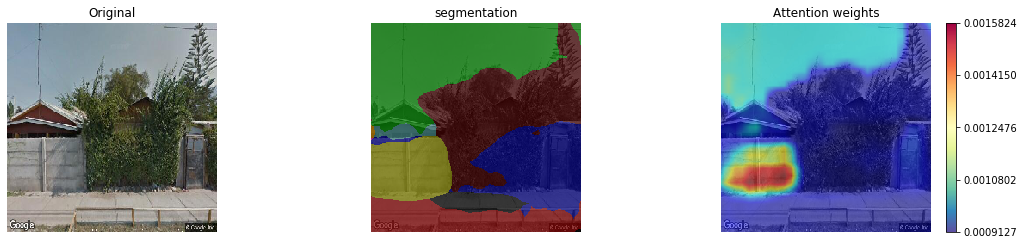

In [8]:
torch.set_printoptions(precision=10)

segmentation = forward_dict['segmentation'][0]
normalize = 'local'
titles = {
    0: 'Original',
    1: 'segmentation'
}
ticks = {}
seg_classes = np.argmax(segmentation, axis=0)
attention_map = shape_attention(forward_dict['attention'][0][0])
seg_img, attentions, _ticks = image_log(segmentation, original_image, attention_map, get_palette(19), normalize)
titles[2] = f'Attention weights'
ticks[2] = _ticks

print(f"Score. {attribute}: {forward_dict['output'][0].item()}")
print(f"Prob.  {attribute}: {nn.Sigmoid()(forward_dict['output']).item()}")
show_layout([original_image, seg_img] + attentions, titles, ticks)

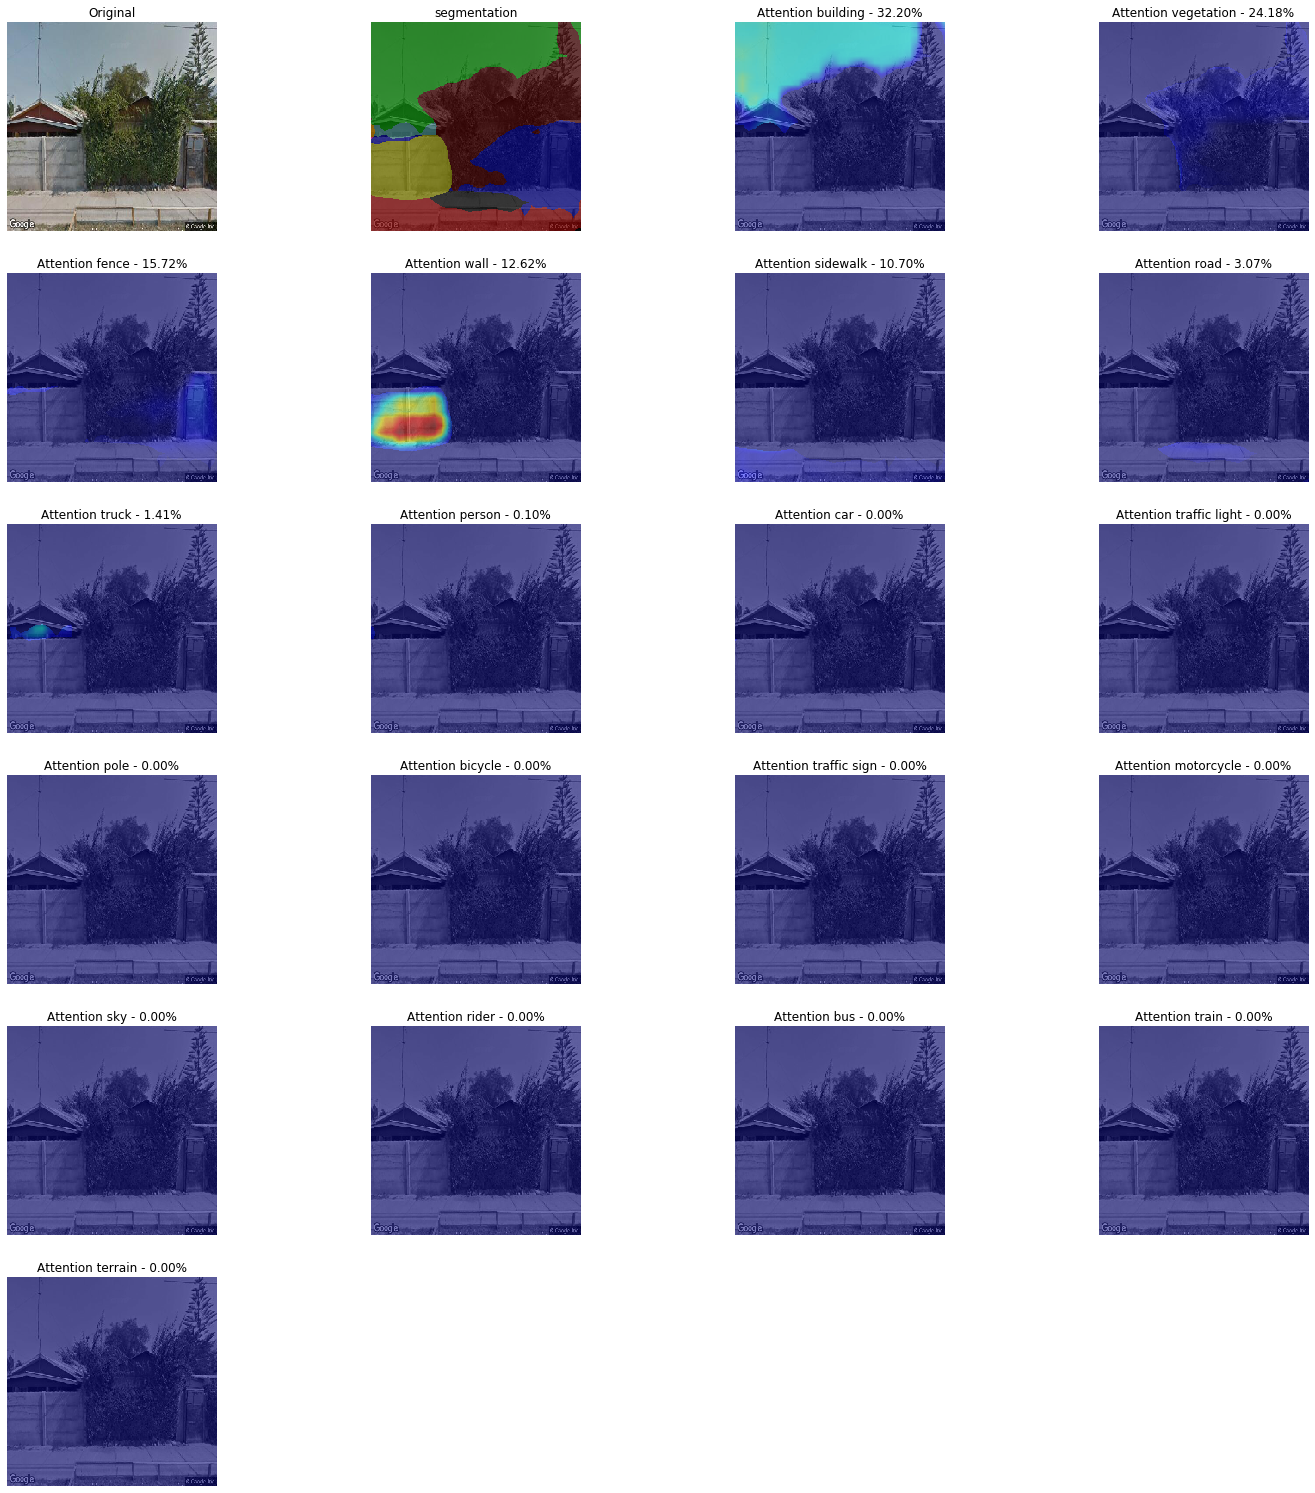

In [9]:
attn_mattrix = attention_map.squeeze()
titles = {
    0: 'Original',
    1: 'segmentation'
}
masked, images = masked_attention_images(original_image, segmentation, attention_map)
seg_img = segmentation_to_image(segmentation, original_image, get_palette(19))

sums = np.fromiter(map(lambda x: x.sum(), masked), dtype=np.float)
total = masked.sum()
sorted_idx = sums.argsort()[::-1]
for i, idx in enumerate(sorted_idx):
    titles[i + 2] = f'Attention {CS_CLASSES[idx]} - {(masked[idx].sum() * 100 / total):.2f}%'
images = list(images[sorted_idx])
show_layout([original_image, seg_img] + images, titles, [])